# Step 1: Import CPTAC Data and Define Correlation Functions

In [1]:
import cptac
import cptac.utils as ut
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics as st
import load_data
import get_correlations

In [2]:
#Make docstrings for what is required
def get_single_gene_correlations(gene, cancer_type_list,type_dict,input_tissue_type = "tumor"):
    correlation_list = []
    type_list = []
    pval_list = []
    for cancer in cancer_type_list:
        correlation,pval,num_samples = get_correlations.correlation_list(cancer, [gene],tissue_type = input_tissue_type)
        if len(correlation) == 0:
            continue
        else:
            correlation_list.append(correlation[0])
            pval_list.append(pval[0][1])
            type_list.append(type_dict[cancer])
    return correlation_list, type_list, num_samples, pval_list

In [3]:
def make_df_with_genes(gene_list,cancer_list,name_dict,tissue_type):
    all_genes = []
    all_correlations = []
    all_cancer_types = []
    all_pvals = []
    for gene in gene_list:
        gene_corr_list,type_list,num_samples, pval_list = get_single_gene_correlations(gene,cancer_list,name_dict,tissue_type)
        gene_x,gene_y = get_x_y(gene_corr_list)
        all_genes.extend(gene_x)
        all_correlations.extend(gene_y)
        all_cancer_types.extend(type_list)
        all_pvals.extend(pval_list)
    df = pd.DataFrame(list(zip(all_genes,all_correlations,all_cancer_types, all_pvals)), columns =['Gene', 'Correlation','Cancer', 'p-val'])
    return(df)

In [4]:
def get_x_y(correlation_list):
    x = []
    y = []
    for item in correlation_list:
        x.append(item[0])
        y.append(item[1])
    return x,y

# Step 2: Define Desired Cancer Types

In [5]:
ccrcc = cptac.Ccrcc()
en = cptac.Endometrial()
luad = cptac.Luad()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-5-5c25f03e6d4a>, line 5)


In [6]:
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [7]:
type_dict = {ccrcc:"ccrcc",en:"endometrial",luad:"luad", hnscc:"hnscc",lscc:"lscc"}

# Step 3: Pick Genes and Make Dataframe

The genes shown here were picked from Bailey et al. found [here](https://pubmed.ncbi.nlm.nih.gov/29625053/)

In [8]:
cancer_genes = ['BRAF','FAT1','IDH1','TP53','KMT2D','KRAS','PIK3CA','PTEN','SPTA1']

In [9]:
tumor_df = make_df_with_genes(cancer_genes,cancer_list,type_dict,tissue_type = "tumor")
tumor_df['Tissue'] = ['Tumor'] * len(tumor_df)

In [10]:
normal_df = make_df_with_genes(cancer_genes,cancer_list,type_dict,tissue_type = "normal")
normal_df['Tissue'] = ['Normal'] * len(normal_df)

In [12]:
# get delta correlation p-values
delta_corr_pvals_df = pd.read_csv('data/p_val.csv')

In [13]:
combined_df = pd.merge(normal_df, tumor_df, how = 'outer')
combined_df['Significant Correlation'] = combined_df['p-val'] <= 0.05
delta_corr_pvals = []
for index, row in combined_df.iterrows():
    cancer = row['Cancer']
    gene = row['Gene']
    pval = delta_corr_pvals_df[delta_corr_pvals_df.Cancer == cancer].reset_index()[gene][0]
    delta_corr_pvals.append(pval)
combined_df['delta_corr_pval'] = delta_corr_pvals
combined_df['Significant Delta Correlation'] = combined_df['delta_corr_pval'] <= 0.05

# Step 4: Plot Data

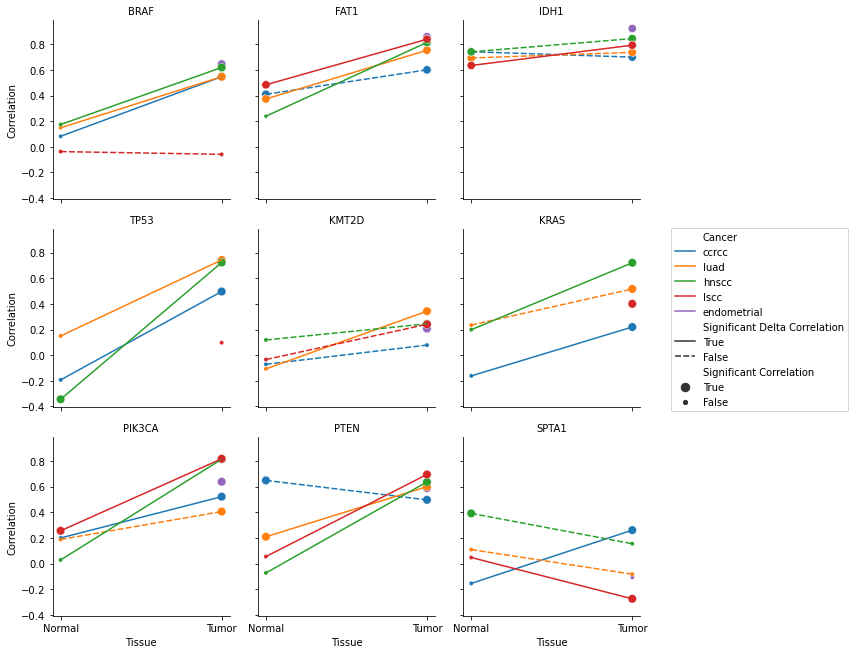

In [15]:
g = sns.FacetGrid(combined_df, col ='Gene', height = 3, col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'Tissue', y = 'Correlation', hue = 'Cancer', palette='tab10', size = 'Significant Correlation', size_order = [True, False])
g.map_dataframe(sns.lineplot, x = 'Tissue', y = 'Correlation', hue = 'Cancer', palette='tab10', style = 'Significant Delta Correlation', style_order = [True, False], label = '_Hidden')
g.set_axis_labels('Tissue', 'Correlation')
#g.add_legend()
g.set_titles('{col_name}')
current_handles, current_labels = plt.gca().get_legend_handles_labels()
del current_labels[9:15]
del current_handles[9:15]
plt.legend(current_handles, current_labels, bbox_to_anchor=(2.2, 2.2))
plt.savefig('Figures/Figure 10 Interesting Cancer Genes Correlation Change.png', bbox_inches='tight')

In [23]:
combined_df

,Gene,Correlation,Cancer,p-val,Tissue,Significant Correlation,delta_corr_pval,Significant Delta Correlation
0,BRAF,0.081654,ccrcc,0.486158,Normal,False,0.000483,True
1,BRAF,0.147973,luad,0.139744,Normal,False,0.000891,True
2,BRAF,0.173692,hnscc,0.271302,Normal,False,0.003473,True
3,BRAF,-0.037786,lscc,0.717671,Normal,False,0.881426,False
4,FAT1,0.409362,ccrcc,0.000266,Normal,True,0.089455,False
...,...,...,...,...,...,...,...,...
72,SPTA1,0.260784,ccrcc,0.005929,Tumor,True,0.005476,True
73,SPTA1,-0.107490,endometrial,0.299819,Tumor,False,0.856207,False
74,SPTA1,-0.082873,luad,0.389384,Tumor,False,0.168537,False
75,SPTA1,0.154798,hnscc,0.108009,Tumor,False,0.168930,False
